# hw2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess

from astropy import units as u
from astropy.io import fits
from astropy.time import Time
from collections import namedtuple
from datetime import datetime, timezone, timedelta
from glob import glob
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator
from os import makedirs, rename
from os.path import basename, exists, join
from shutil import rmtree
from skyfield import almanac
from skyfield.api import load, wgs84
from tqdm.auto import tqdm


plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.top'] = True
plt.rcParams['xtick.major.bottom'] = True
plt.rcParams['xtick.minor.top'] = True
plt.rcParams['xtick.minor.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.major.left'] = True
plt.rcParams['ytick.major.right'] = True
plt.rcParams['ytick.minor.left'] = True
plt.rcParams['ytick.minor.right'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

exex > *Atmosphere*, Numerics and Data Exercises, #3

> Take ten random plates from the BOSS spectroscopic survey in SDSS. Determine the phase and altitude of the Moon for the time of each observation, and sort by the Moon illumination. If the Moon altitude is below the horizon, treat the illumination as zero. Plot the mean sky spectrum from the sky fibers for each plate on the same plot, labeled according to Moon illumination, and comment on what you find.

We can get images of the spectra for each fiber of the BOSS plates at
https://skyserver.sdss.org/dr18/MoreTools/plate
but we can't get the actual spectrum data here.

There is 
https://dr15.sdss.org/optical/plate/search

I used the following search to get a list of BOSS plates.
- Select Survey > `boss`
- Select Program > `boss`
- Select Quality > `good`

From these, I picked every ~5th plate. Clicking on the plate gives the corresponding 'spectrum search'. By default, this excludes the sky fibers. We can change this by changing the ZWARNING search parameter to "Matches Any (&) of the following flags: Sky (0) (on)". For each plate, I downloaded the `rsync`-compatible download-file to get these sky fibers. Then, for each of these files, we can fetch the spectra by running

```
rsync -avzL --files-from=<download_rsync.txt> rsync://dtn.sdss.org/dr15  dr15
```

This places the files _deep_ in a bunch of folders, so we'll also flatten that out.

In [2]:
rsync_files = sorted(glob("rsync-files/*"))
print(len(rsync_files), 'plates to download')

output_dir = "dr15"
data_dir = "data"

if not exists(data_dir):

    for f in rsync_files:
        subprocess.run([
            "rsync",
            "-aqzL",
            "--files-from",
            f,
            "rsync://dtn.sdss.org/dr15",
            output_dir
        ])
    
    makedirs(data_dir, exist_ok=True)
    
    for f in rsync_files:
        with open(f, 'r') as file:
            lines = file.readlines()
            for line in lines:
                path = join(output_dir, line.strip()[1:])
                rename(path, join(data_dir, basename(path)))
    
    rmtree(output_dir)

else:
    print('already downloaded!')

10 plates to download
already downloaded!


Let's look at the files now.

In [3]:
spec_files = sorted(glob('data/*'))
print(len(spec_files), 'spectra downloaded.')

896 spectra downloaded.


The filenames are `spec-{plate number}-{mjd}-{fiber id}.fits`.

In [4]:
Spec = namedtuple('Spec', ['plate', 'mjd', 'fiber'])

def parse_filename(filepath):
    filename = basename(filepath)
    plate, mjd, fiber = filename.split('.')[0].split('-')[1:]
    return Spec(int(plate), int(mjd), int(fiber))

parse_filename(spec_files[0])

Spec(plate=3655, mjd=55240, fiber=18)

Let's crack open one of the files and see what kind of data we're working with.

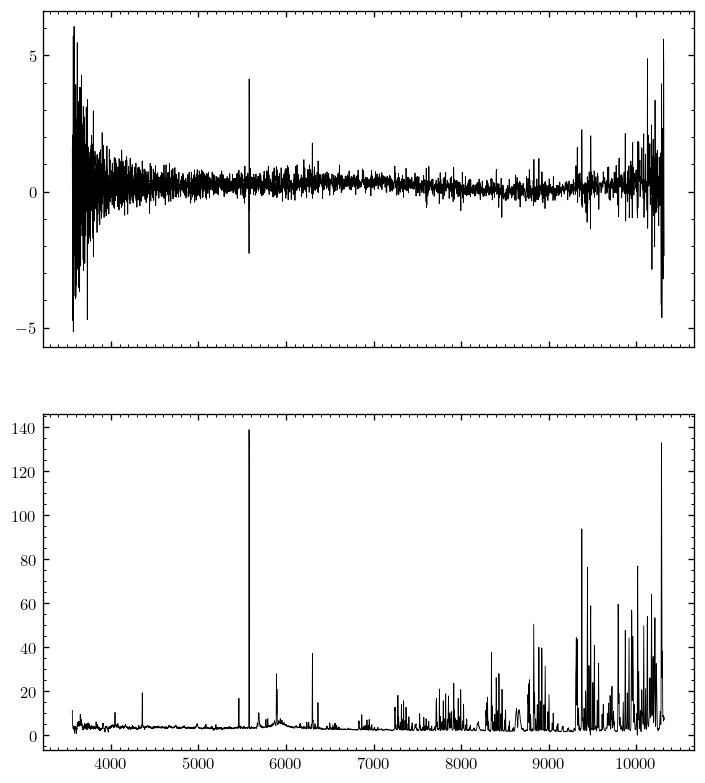

In [5]:
_data = fits.getdata(spec_files[0])

loglam = _data['loglam']
flux   = _data['flux']
sky    = _data['sky']

lam = 10 ** loglam

fig, axs = plt.subplots(2, 1, figsize=(7, 8), sharex=True)
axs[0].plot(lam, flux, lw=0.5, c='k')
axs[0].xaxis.set_major_locator(MultipleLocator(1000))
axs[0].xaxis.set_minor_locator(MultipleLocator(100))
axs[0].yaxis.set_major_locator(MultipleLocator(5))
axs[0].yaxis.set_minor_locator(MultipleLocator(1))

axs[1].plot(lam, sky, lw=0.5, c='k')
axs[1].xaxis.set_major_locator(MultipleLocator(1000))
axs[1].xaxis.set_minor_locator(MultipleLocator(100))
axs[1].yaxis.set_major_locator(MultipleLocator(20))
axs[1].yaxis.set_minor_locator(MultipleLocator(5))
plt.show()

For each of these plates, we want to compute the mean sky spectrum over all the sky fibers.

The sky spectrum data are not all at the same wavelengths, though, so we need to average them together in a smart way.

They are _mostly_ at the same wavelengths, though — e.g. there is a list of discrete wavelengths which are possible, and though they all have different subsets of that list, the overlaps are exact. Thus, we can take the average over the observations _at each possible wavelength_.

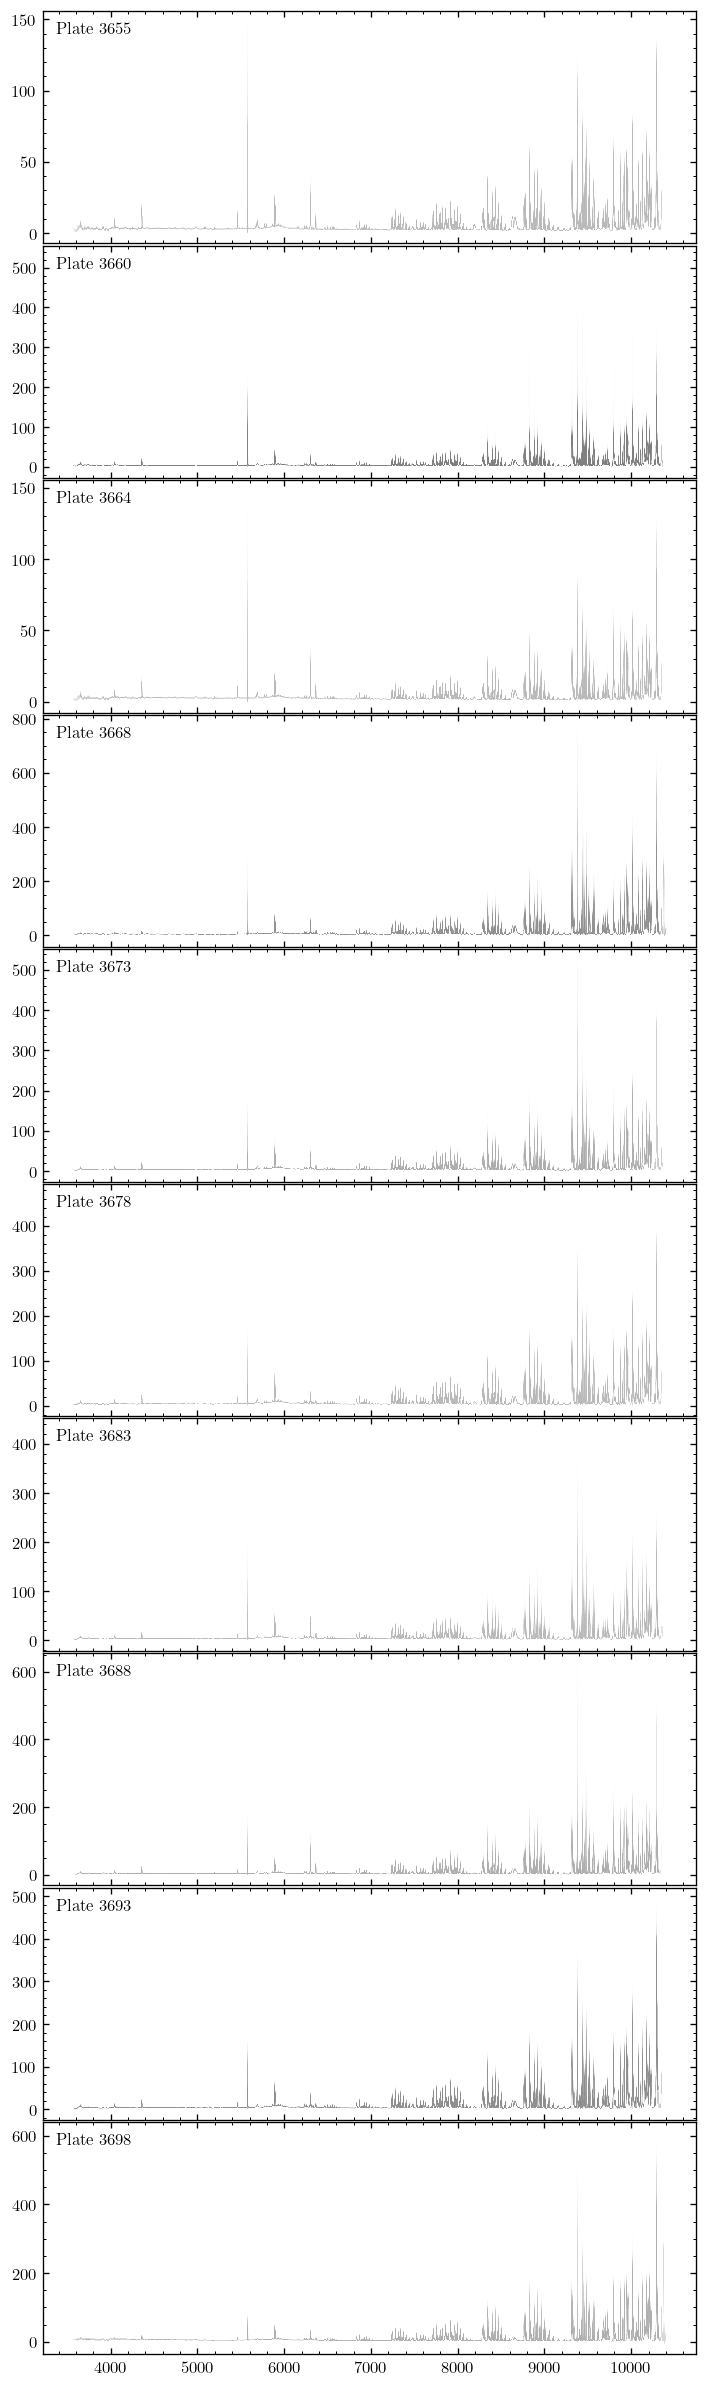

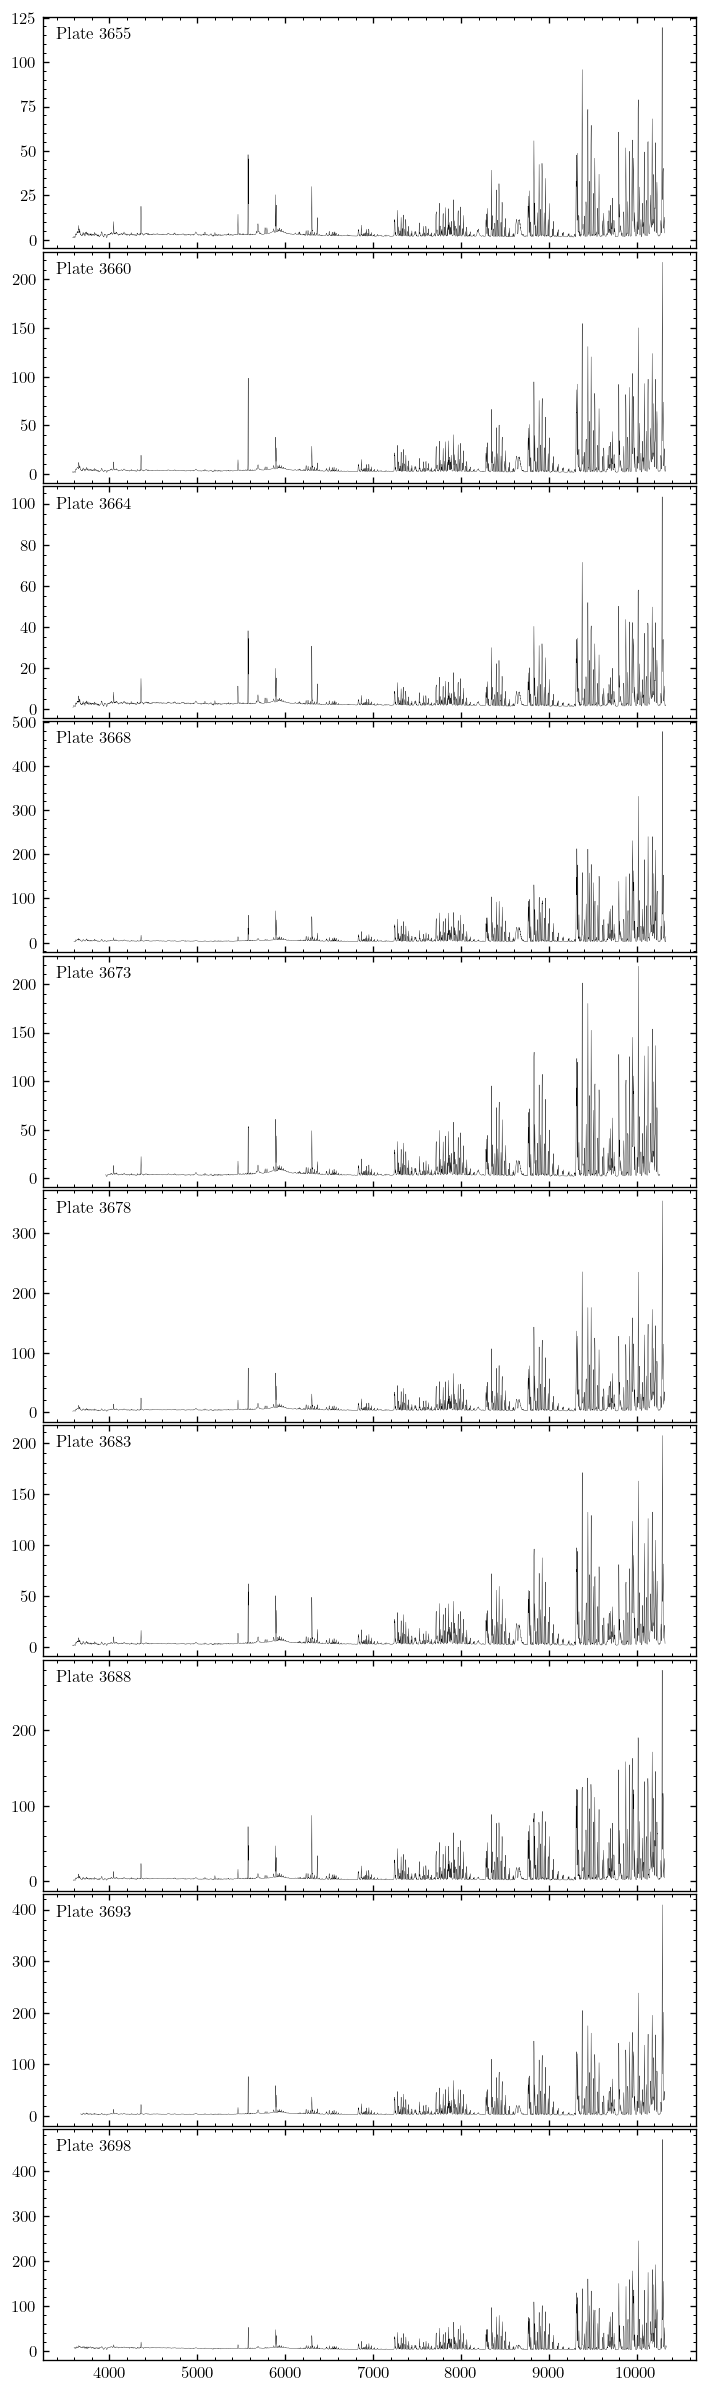

In [6]:
plates = [parse_filename(f)[0] for f in spec_files]
plates = np.array(plates)

uniques = np.unique(plates)

fig, axs = plt.subplots(len(uniques), 1, figsize=(6, 2 * len(uniques)), sharex=True)

lams, skys = [], []

for i, p in enumerate(uniques):
    ax = axs[i]
    mask = (plates == p)

    _lams, _skys = [], []
    
    for j in np.where(mask)[0]:
        data = fits.getdata(spec_files[j])
        lam = 10 ** data['loglam']
        sky = data['sky']

        _lams.append(lam)
        _skys.append(sky)
        
        ax.plot(lam, sky, lw=0.1, c=(0.5,0.5,0.5), alpha=0.01)

    ax.text(0.02, 0.95, f"Plate {p}", transform=ax.transAxes, ha='left', va='top')

    # find the list of possible wavelength values
    x = np.sort(np.unique(np.concatenate(_lams)))

    # rectangularize our data
    all_y = np.zeros((len(_lams), len(x))) * np.nan
    for i, (spec_x, spec_y) in enumerate(zip(_lams, _skys)):
        all_y[i, np.searchsorted(x, spec_x)] = spec_y

    # compute averages for each wavelength
    y = np.average(all_y, axis=0)

    lams.append(x)
    skys.append(y)

fig.tight_layout(h_pad=0)
plt.show()




fig, axs = plt.subplots(len(uniques), 1, figsize=(6, 2 * len(uniques)), sharex=True)

for i, p in enumerate(uniques):
    ax = axs[i]
    x = lams[i]
    y = skys[i]
    
    ax.plot(x, y, lw=0.2, c='k')
    ax.text(0.02, 0.95, f"Plate {p}", transform=ax.transAxes, ha='left', va='top')

fig.tight_layout(h_pad=0)
plt.show()

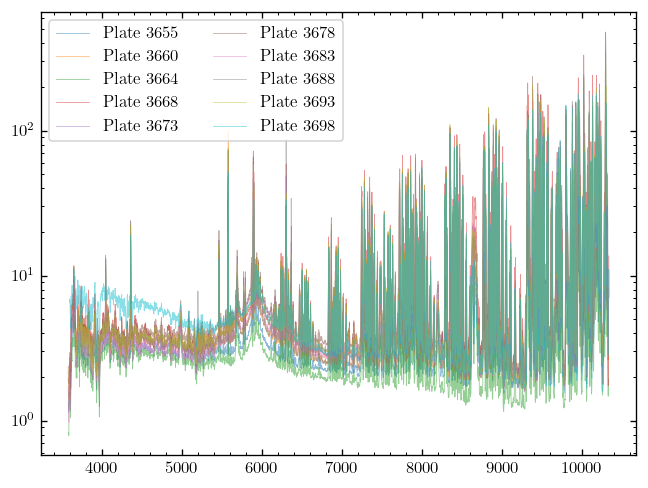

In [7]:
fig, ax = plt.subplots()
for x, y in zip(lams, skys):
    ax.plot(x, y, lw=0.5, alpha=0.5)
ax.set_yscale('log')
ax.legend([f"Plate {p}" for p in uniques], ncol=2)
plt.show()

Now let's look up the Moon details. To do this, we'll need the times of the exposures. 

The exposures are listed in the header of each spectrum file. We only need to analyze one per plate (since all the spectra in a given plate were taken simultaneously). For each exposure file, we'll connect to the SDSS dtn and get the file modified time of the raw exposure file. These aren't modified after they're taken, so the file `mtime` is an accurate estimator of the exposure time.

In [8]:
all_plate_times = []

for p in uniques:
    index = np.where(p == plates)[0][0]
    mjd = parse_filename(spec_files[index])[1]
    head = fits.getheader(spec_files[index])
    n_exp = int(head['NEXP'])
    exposures = [head[f'EXPID{e+1:02d}'][:11] for e in range(n_exp)]
    raw_data_files = [f"prior-surveys/sdss3-dr12-boss/spectro/data/{mjd}/sdR-{exp}.fit.gz" for exp in exposures]

    plate_times = []

    for exp in tqdm(exposures, unit='exposure', desc=f'Plate {p}'):

        # exposures aren't always located in the correct MJD folder, but they're close, so we'll search backward up to 5 days
        for i in range(5):
            filepath = f"prior-surveys/sdss3-dr12-boss/spectro/data/{mjd - i}/sdR-{exp}.fit.gz"
            command = f'rsync --dry-run --itemize-changes --no-motd --out-format="%M %f" rsync://dtn.sdss.org/dr18/{filepath} .'
            result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

            if result.returncode == 0:  # found it!
                break
            elif result.returncode == 23:  # this means FileNotFound, so continue
                continue
            else:  # we're not expecting any other errors, so raise if one occurs
                raise RuntimeError(result)

        else:
            # if we didn't find it in any of the nearby MJD folders, just take a None
            if result.returncode != 0:
                plate_times.append(None)

        # we found it! let's parse it into a astropy.time.Time
        _date, _time = result.stdout.split()[0].split('-')
        y, mo, d = map(int, _date.split('/'))
        h, mi, s = map(int, _time.split(':'))
        t = Time(datetime(y, mo, d, h, mi, s, tzinfo=timezone(timedelta(hours=-6))))
        plate_times.append(t)
    
    all_plate_times.append(plate_times)

Plate 3655:   0%|          | 0/10 [00:00<?, ?exposure/s]

Plate 3660:   0%|          | 0/16 [00:00<?, ?exposure/s]

Plate 3664:   0%|          | 0/8 [00:00<?, ?exposure/s]

Plate 3668:   0%|          | 0/16 [00:00<?, ?exposure/s]

Plate 3673:   0%|          | 0/16 [00:00<?, ?exposure/s]

Plate 3678:   0%|          | 0/14 [00:00<?, ?exposure/s]

Plate 3683:   0%|          | 0/18 [00:00<?, ?exposure/s]

Plate 3688:   0%|          | 0/10 [00:00<?, ?exposure/s]

Plate 3693:   0%|          | 0/12 [00:00<?, ?exposure/s]

Plate 3698:   0%|          | 0/10 [00:00<?, ?exposure/s]

With these times, we can use the SkyField package to figure out where everything was. I'm choosing to use the most recent JPL ephemeris, `de440s.bsp`, issued in 2020.

SkyField's `almanac.moon_phase` gives the phase of the moon in degrees, i.e. 

> 0° is New Moon, 90° is First Quarter, 180° is Full Moon, and 270° is Last Quarter

We'll convert this into a simple illumination fraction as follows

$$
\text{illumination fraction} = 1 - \frac{\left| \text{moon phase} - 180^\circ \right|}{180^\circ}
$$

which is zero for a new moon and 1 for a full moon.

To get the moon altitude, we need to compute its position relative to APO. To get the latitude, longitude, and elevation of APO, I used Google Maps data.
- https://www.google.com/maps/search/Apache%20Point%20Observatory and right-click to get lat/lon
- https://www.randymajors.org/elevation-on-google-maps to find the elevation in the Google Maps data at that point

In [9]:
ts = load.timescale()
eph = load('de440s.bsp')

earth = eph['Earth']
moon  = eph['Moon']

apo = earth + wgs84.latlon(32.78063634463345, -105.81997438465828, elevation_m=2796)

illuminations = []

for p, plate_times in zip(uniques, all_plate_times):
    _times = Time(np.array([ pt.mjd for pt in plate_times ]), format='mjd')
    
    # compute the moon altitude and phase at exposure time
    _alts  = np.array([ apo.at(ts.from_astropy(_t)).observe(moon).apparent().altaz()[0].degrees for _t in _times ]) * u.deg
    _phases = np.array([almanac.moon_phase(eph, ts.from_astropy(_t)).degrees for _t in _times]) * u.deg

    # use our illumination fraction formula
    _illuminations = 1 - (np.abs(_phases - 180 * u.deg) / (180 * u.deg)).value
    _illuminations[_alts < 0 * u.deg] = np.nan

    # average the illuminations of exposures where moon was above the horizon
    if np.isnan(_illuminations).all():
        illuminations.append(0)
    else:
        illuminations.append(np.nanmean(_illuminations))

illuminations = np.array(illuminations)
print(illuminations)

[0.         0.         0.         0.01640623 0.19043421 0.
 0.25956726 0.         0.         0.35050209]


All ten plates:


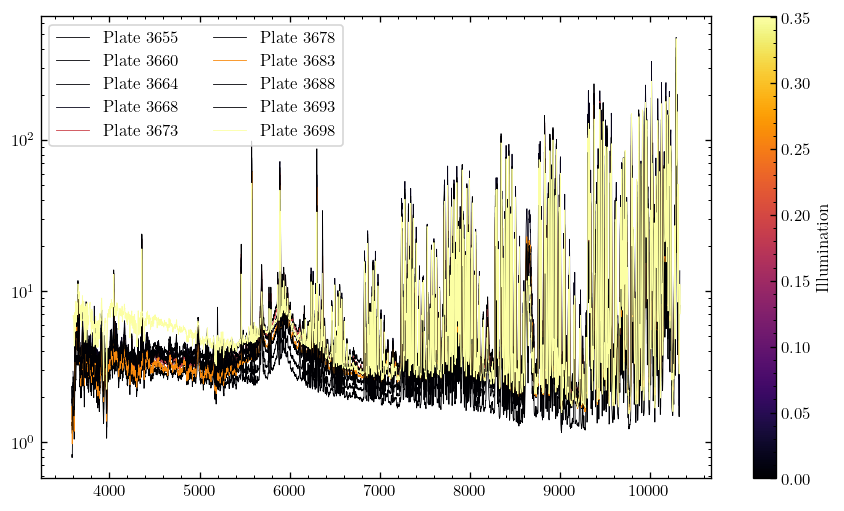

Just those with nonzero illumination:


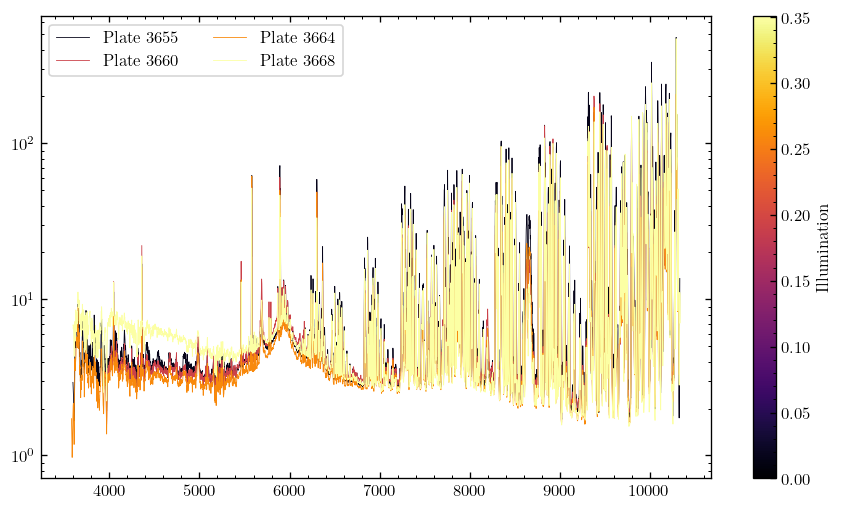

In [10]:
cmap = plt.get_cmap('inferno')
norm = Normalize(vmin=0, vmax=illuminations.max())

print('All ten plates:')
fig, ax = plt.subplots(figsize=(9, 5))
for x, y, i in zip(lams, skys, illuminations):
    ax.plot(x, y, lw=0.5, alpha=1, color=cmap(norm(i)))
ax.set_yscale('log')
ax.legend([f"Plate {p}" for p in uniques], ncol=2)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=ax, label='Illumination')
plt.show()


print('Just those with nonzero illumination:')
fig, ax = plt.subplots(figsize=(9, 5))
for x, y, i in zip(lams, skys, illuminations):
    if i != 0:
        ax.plot(x, y, lw=0.5, alpha=1, color=cmap(norm(i)))
ax.set_yscale('log')
ax.legend([f"Plate {p}" for p in uniques], ncol=2)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=ax, label='Illumination')
plt.show()

Unfortunately only one of my plates really has high illumination. This plate, though, shows substantially higher flux at lower wavelengths than any of the other plates, so I think we can clearly see that the presence of a bright moon results in an increased sky background.